In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"
data = pd.read_csv(url)

In [3]:
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [ ]:
# Check for missing values
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


In [ ]:
# Summary statistics
print("\nSummary Statistics:\n", data.describe())


Summary Statistics:
                UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]  Machine failure  \
count            10000.000000  10000.000000     10000.000000     10000.000000   
mean              1538.776100     39.986910       107.951000         0.033900   
std                179.284096      9.968934        63.654147         0.180981   
min               1168.000000      3.8000

<Figure size 1200x600 with 0 Axes>

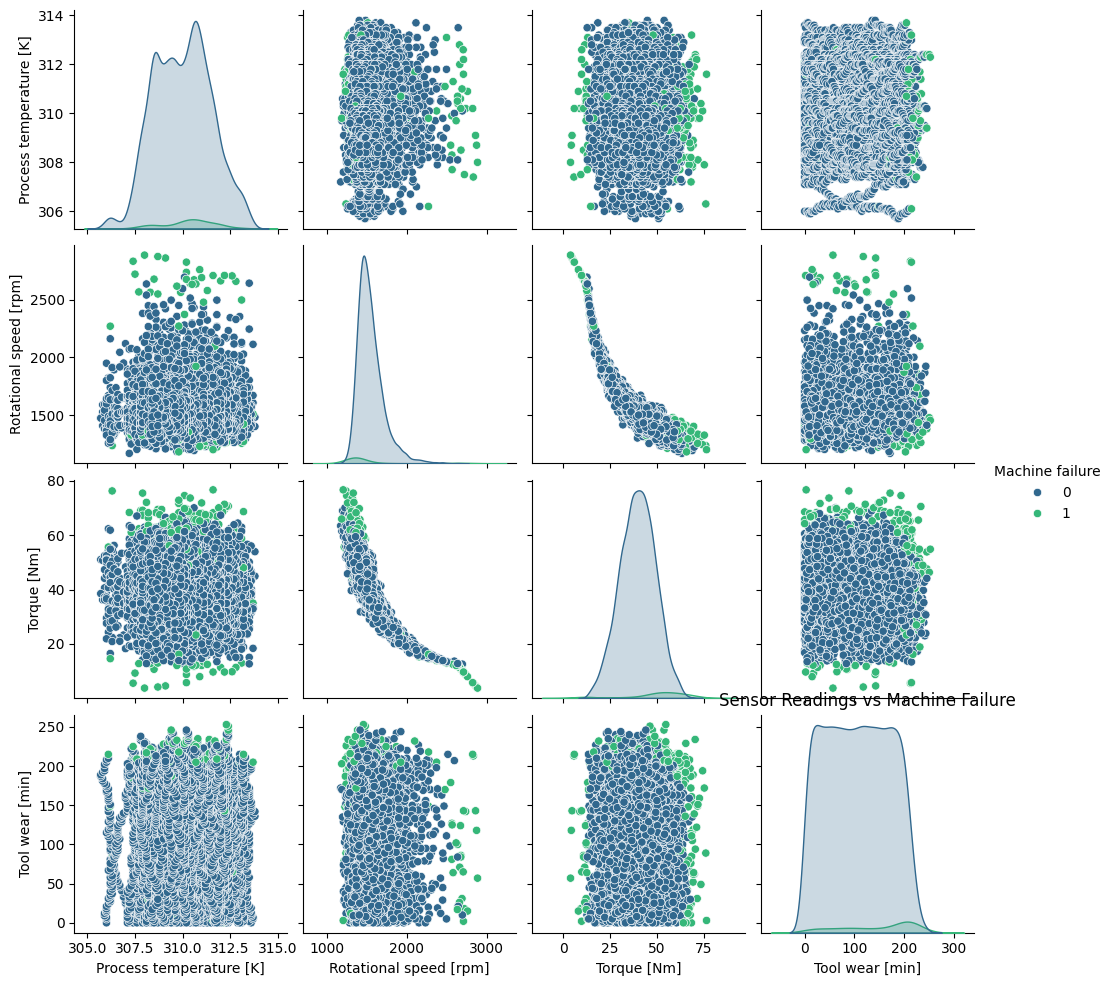

In [ ]:
# Visualizing sensor trends
plt.figure(figsize=(12, 6))
sns.pairplot(data[['Process temperature [K]', 'Rotational speed [rpm]',
                   'Torque [Nm]', 'Tool wear [min]', 'Machine failure']],
             hue='Machine failure', palette='viridis')
plt.title("Sensor Readings vs Machine Failure")
plt.show()

In [ ]:
# Create an in-memory SQLite database
from sqlite3 import connect
# Establishing connection
conn = connect(':memory:')
data.to_sql('sensor_data', conn, if_exists='replace', index=False)  # Loading data into SQL
# Run SQL queries
query1 = """
SELECT
    type AS Machine_Type,
    COUNT(*) AS Total_Machines,
    SUM("Machine failure") AS Failures,
    ROUND((SUM("Machine failure") * 100.0 / COUNT(*)), 2) AS Failure_Rate
FROM sensor_data
GROUP BY type
ORDER BY Failure_Rate DESC
"""

query2 = """
SELECT
    AVG("Process temperature [K]") AS Avg_Temp,
    AVG("Rotational speed [rpm]") AS Avg_RPM,
    AVG("Torque [Nm]") AS Avg_Torque,
    AVG("Tool wear [min]") AS Avg_Tool_Wear
FROM sensor_data
WHERE "Machine failure" = 1
"""

In [ ]:
# Execute and display results
print("Failure Rate by Machine Type:")
display(pd.read_sql(query1, conn))

print("\nAverage Sensor Readings Before Failure:")
display(pd.read_sql(query2, conn))

Failure Rate by Machine Type:


,Machine_Type,Total_Machines,Failures,Failure_Rate
0,L,6000,235,3.92
1,M,2997,83,2.77
2,H,1003,21,2.09



Average Sensor Readings Before Failure:


,Avg_Temp,Avg_RPM,Avg_Torque,Avg_Tool_Wear
0,310.290265,1496.486726,50.168142,143.781711


In [ ]:
# Features & Target
X = data[['Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
y = data['Machine failure']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Predict Tool Wear from other sensors
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled[:, :-1], X_train_scaled[:, -1])  # Last column is Tool Wear
tool_wear_pred = lin_reg.predict(X_test_scaled[:, :-1])

# Evaluate
mse = mean_squared_error(X_test_scaled[:, -1], tool_wear_pred)
print(f"Linear Regression MSE for Tool Wear Prediction: {mse:.4f}")

Linear Regression MSE for Tool Wear Prediction: 1.0600


In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred_log))
print(f"Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2907
           1       0.79      0.25      0.38        93

    accuracy                           0.97      3000
   macro avg       0.88      0.62      0.68      3000
weighted avg       0.97      0.97      0.97      3000

Accuracy: 0.9747


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
display(feature_importance)


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2907
           1       0.80      0.44      0.57        93

    accuracy                           0.98      3000
   macro avg       0.89      0.72      0.78      3000
weighted avg       0.98      0.98      0.98      3000

Accuracy: 0.9793

Feature Importance:


,Feature,Importance
2,Torque [Nm],0.368626
1,Rotational speed [rpm],0.260643
3,Tool wear [min],0.226178
0,Process temperature [K],0.144553


<ipython-input-16-8393bd0fdf43>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracy, palette='coolwarm')


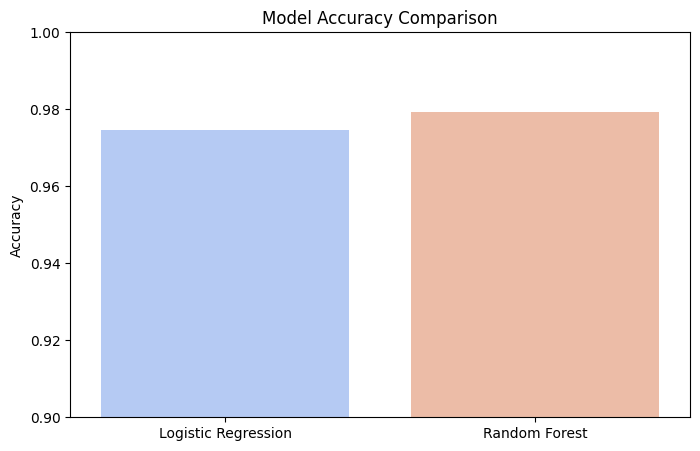

In [ ]:
# Compare Model Accuracy
models = ['Logistic Regression', 'Random Forest']
accuracy = [accuracy_score(y_test, y_pred_log), accuracy_score(y_test, y_pred_rf)]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracy, palette='coolwarm')
plt.ylim(0.9, 1.0)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()